# Capstone Project - Battle of Neighborhoods

## Finding the best area to set up a small boutique cafe in Manhattan, NY

Author: Danielle O Sullivan <br>
Data: 08 August 2020

## 1. Introduction

### Background

New York City is one of the most diverse cities in the world bursting with attractions. With over 3000 coffee shops in New York it can be said that New Yorkers love their coffee. Recently, MassiveHealth found that New Yorkers drink 6.7 times the amount of coffee consumed by the average denizen of any other US city. -https://medium.com/topos-ai/the-next-wave-predicting-the-future-of-coffee-in-new-york-city-23a0c5d62000.

### Business Problem

Selecting a location in New York to open a new boutique cafe is crucial to a businesses’ success. <br>
<br>There are many factors to consider when choosing the location of this new business:<br>
1.	Nearby Venues: Other cafes, restaurants, gyms, etc.
2.	Crime: Will employees be safe coming to/leaving work, will there be people visiting this area
3.	Nearby subway stations: a coffee shop near a subway station might attract more visitors <br>
In this project we will analyse the above factors to determine which area would be the best to open this new café. We will be looking at neighbourhoods in the Manhattan borough only.


## 2. Data

For this analysis, the following datasets were used:
    
New York City Data - https://cocl.us/new_york_dataset <br>
Neighborhood Tabulation Areas - https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas-NTA-/cpf4-rkhq<br>
Foursquare API Data - Foursquare data will be used to explore each neighborhood in Manhattan and venues nearby each of the coordinates in the New York City data.  <br>
NY Crime Data -https://data.cityofnewyork.us/Public-Safety/Crime-Map-/5jvd-shfj <br>
Subway Entrances Data -https://data.cityofnewyork.us/Transportation/Subway-Entrances/drex-xx56 <br>

### Load Libraries

In [3]:
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.



In [67]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import json

# import k-means from clustering stage
from sklearn.cluster import KMeans
import matplotlib.path as mpltPath
import folium 
from folium.plugins import MarkerCluster
print("Libraries imported")

Libraries imported


First we will load the New York Neighborhood Tabulation Areas data json file 

In [232]:
content= requests.get("https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON")
ny_tab_area_json = json.loads(content.content) 

Next we will create Polygons to hold the Tabulation Data. We will then create a function to define the tabulation area using the latitude and longitude. This will be used for all other data files to add the tabulation area.

In [233]:
# Create New York Area Tabulation Data Polygons
neighborhoods_polygons = {}
for neighborhood in ny_tab_area_json['features']:
    name = neighborhood['properties']['ntaname']
    neighborhoods_polygons[name] = neighborhood['geometry']

In [234]:
# Function to define NYC Tab Area by latitude, longitude
def define_tab_area(latitude, longitude):
    point = [[longitude,latitude]]
    for k,v in neighborhoods_polygons.items():                
        polygon_shapes = v['coordinates']      
        if len(polygon_shapes) == 1:
            path = mpltPath.Path(polygon_shapes[0][0])
            if path.contains_points(point):
                return k
        else:
            for p in polygon_shapes:
                path = mpltPath.Path(p[0])
                if path.contains_points(point):
                    return k        
    return 'Not defined'
        
define_tab_area(40.746851229,-73.9857242879999)

'Midtown-Midtown South'

Next we will load the New York City json file and transform to a dataframe

In [6]:
content = requests.get("https://cocl.us/new_york_dataset/newyork_data.json")
ny_json = json.loads(content.content)  
print('Data downloaded!')

Data downloaded!


In [7]:
neighborhoods_data = ny_json['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [8]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

#create dataframe
neighborhoods_df = pd.DataFrame(columns=column_names)
neighborhoods_df

,Borough,Neighborhood,Latitude,Longitude


In [9]:
for data in neighborhoods_data:
    borough = neighborhood_name=data['properties']['borough']
    neighborhood_name = data['properties']['name']
    
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods_df=neighborhoods_df.append({'Borough': borough,
                                              'Neighborhood': neighborhood_name,
                                              'Latitude': neighborhood_lat,
                                              'Longitude':neighborhood_lon},ignore_index=True)
    
neighborhoods_df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


We now have a dataframe with all the neighborhoods in New York with their latitude and longitude. To confirm the data is correct we will check there is 5 Boroughs and 306 neighborhoods

In [10]:
print('This dataframe has {} boroughs and {} neighborhoods in New York City'.format(len(neighborhoods_df['Borough'].unique()),neighborhoods_df.shape[0]))

This dataframe has 5 boroughs and 306 neighborhoods in New York City


As we are only looking at Manhattan for this project we will create a new dataframe with only Manhattan Data

In [11]:
manhattan_df=neighborhoods_df[neighborhoods_df['Borough']=='Manhattan'].reset_index(drop=True)
manhattan_df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


We will use the function we created earlier to define the tabulation area and add it to the dataframe as tab_area

In [123]:
manhattan_df['tab_area'] =  manhattan_df.apply(lambda row : define_tab_area(row['Latitude'], row['Longitude']), axis = 1)
manhattan_df.head()

,Borough,Neighborhood,Latitude,Longitude,tab_area
0,Manhattan,Marble Hill,40.876551,-73.910660,Marble Hill-Inwood
1,Manhattan,Chinatown,40.715618,-73.994279,Chinatown
2,Manhattan,Washington Heights,40.851903,-73.936900,Washington Heights North
3,Manhattan,Inwood,40.867684,-73.921210,Marble Hill-Inwood
4,Manhattan,Hamilton Heights,40.823604,-73.949688,Hamilton Heights


In [125]:
manhattan_df['tab_area'].unique()

array(['Marble Hill-Inwood', 'Chinatown', 'Washington Heights North',
       'Hamilton Heights', 'Manhattanville',
       'Central Harlem North-Polo Grounds', 'East Harlem South',
       'Upper East Side-Carnegie Hill', 'Yorkville',
       'Lenox Hill-Roosevelt Island', 'Upper West Side', 'Lincoln Square',
       'Hudson Yards-Chelsea-Flatiron-Union Square',
       'Midtown-Midtown South', 'Murray Hill-Kips Bay',
       'SoHo-TriBeCa-Civic Center-Little Italy', 'East Village',
       'Lower East Side', 'West Village', 'Morningside Heights',
       'Gramercy', 'Battery Park City-Lower Manhattan',
       'Turtle Bay-East Midtown', 'Stuyvesant Town-Cooper Village'],
      dtype=object)

Read in Crime data csv file to dataframe

In [44]:
crime_data=pd.read_csv('https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD')
crime_data.head()                     

C:\Users\Danielleos\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (18,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,JURISDICTION_CODE,PARKS_NM,HADEVELOPT,HOUSING_PSA,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,325341655,02/11/2015,15:00:00,NaN,NaN,73.0,02/11/2015,359,OFFENSES AGAINST PUBLIC ADMINI,749.0,VIOLATION OF ORDER OF PROTECTI,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,RESIDENCE - PUBLIC HOUSING,N.Y. HOUSING POLICE,2.0,NaN,TILDEN,405,1009656.0,181287.0,25-44,BLACK,M,NaN,40.664239,-73.908425,"(40.664239422, -73.908425011)",PATROL BORO BKLYN NORTH,NaN,<18,BLACK,M
1,393816841,03/17/2012,10:30:00,03/17/2012,11:00:00,69.0,03/17/2012,344,ASSAULT 3 & RELATED OFFENSES,114.0,OBSTR BREATH/CIRCUL,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,RESIDENCE-HOUSE,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,1014035.0,174133.0,NaN,NaN,NaN,NaN,40.644590,-73.892672,"(40.644589618, -73.892672426)",PATROL BORO BKLYN SOUTH,NaN,45-64,BLACK,F
2,802896158,10/27/2016,13:48:00,11/03/2016,13:49:00,71.0,11/03/2016,578,HARRASSMENT 2,638.0,"HARASSMENT,SUBD 3,4,5",COMPLETED,VIOLATION,BROOKLYN,INSIDE,PUBLIC SCHOOL,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,1000222.0,179282.0,<18,BLACK,M,NaN,40.658758,-73.942435,"(40.658758183, -73.942434788)",PATROL BORO BKLYN SOUTH,NaN,18-24,BLACK,M
3,633812343,11/27/2014,19:00:00,11/27/2014,22:30:00,112.0,11/28/2014,104,RAPE,157.0,RAPE 1,COMPLETED,FELONY,QUEENS,INSIDE,RESIDENCE - APT. HOUSE,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,1025420.0,202485.0,25-44,WHITE HISPANIC,M,NaN,40.722364,-73.851474,"(40.722363687, -73.851473894)",PATROL BORO QUEENS NORTH,NaN,25-44,WHITE,F
4,300349533,12/11/2013,13:30:00,12/11/2013,14:15:00,24.0,12/12/2013,109,GRAND LARCENY,438.0,"LARCENY,GRAND FROM BUILDING (NON-RESIDENCE) UN...",COMPLETED,FELONY,MANHATTAN,INSIDE,DOCTOR/DENTIST OFFICE,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,992848.0,228356.0,NaN,NaN,NaN,NaN,40.793465,-73.968950,"(40.793464597, -73.968949638)",PATROL BORO MAN NORTH,NaN,45-64,WHITE,F


In [45]:
crime_data.shape

(6983207, 35)

In [72]:
crime_data.dtypes

CMPLNT_NUM             int64
CMPLNT_FR_DT          object
CMPLNT_FR_TM          object
CMPLNT_TO_DT          object
CMPLNT_TO_TM          object
ADDR_PCT_CD          float64
RPT_DT                object
KY_CD                  int64
OFNS_DESC             object
PD_CD                float64
PD_DESC               object
CRM_ATPT_CPTD_CD      object
LAW_CAT_CD            object
BORO_NM               object
LOC_OF_OCCUR_DESC     object
PREM_TYP_DESC         object
JURIS_DESC            object
JURISDICTION_CODE    float64
PARKS_NM              object
HADEVELOPT            object
HOUSING_PSA           object
X_COORD_CD           float64
Y_COORD_CD           float64
SUSP_AGE_GROUP        object
SUSP_RACE             object
SUSP_SEX              object
TRANSIT_DISTRICT     float64
Latitude             float64
Longitude            float64
Lat_Lon               object
PATROL_BORO           object
STATION_NAME          object
VIC_AGE_GROUP         object
VIC_RACE              object
VIC_SEX       

We will only include the following columns for the analysis

CMPLNT_FR_DT - Complaint first reported date  <br>
LAW_CAT_CD - Law category  <br>
BORO_NM - Borough Name  <br>
Latitide- Latitude  <br>
Longitude- Longitude

In [46]:
crime_df = crime_data[['CMPLNT_FR_DT','LAW_CAT_CD','BORO_NM','Latitude','Longitude']]
crime_df.head()

,CMPLNT_FR_DT,LAW_CAT_CD,BORO_NM,Latitude,Longitude
0,02/11/2015,MISDEMEANOR,BROOKLYN,40.664239,-73.908425
1,03/17/2012,MISDEMEANOR,BROOKLYN,40.644590,-73.892672
2,10/27/2016,VIOLATION,BROOKLYN,40.658758,-73.942435
3,11/27/2014,FELONY,QUEENS,40.722364,-73.851474
4,12/11/2013,FELONY,MANHATTAN,40.793465,-73.968950


Filter crime_df to only include crimes in Manhattan

In [47]:
crime_df=crime_df[crime_df['BORO_NM']=='MANHATTAN'].reset_index(drop=True)
crime_df.head()
crime_df.shape

(1679470, 5)

Filter crime_df to only inlcude felony and misdemeanor crimes

In [48]:
crime_df=crime_df[crime_df.LAW_CAT_CD.isin(['FELONY', 'MISDEMEANOR'])].reset_index(drop=True)
crime_df.shape                   

(1497457, 5)

Filter crime_df to only include crimes from 2019

In [49]:
crime_df=crime_df.dropna(subset=['CMPLNT_FR_DT'])
crime_df.shape     

(1497334, 5)

In [51]:
crime_df=crime_df[crime_df['CMPLNT_FR_DT'].str.contains("2019")].reset_index(drop=True)

In [52]:
crime_df.shape

(98693, 5)

we will use the function define_tab_area to add the tabulation area to the dataframe. We will confirm only the below areas are included

In [53]:
crime_df['tab_area'] =  crime_df.apply(lambda row : define_tab_area(row['Latitude'], row['Longitude']), axis = 1)

In [131]:
crime_df=crime_df[crime_df.tab_area.isin(['Marble Hill-Inwood', 'Chinatown', 'Washington Heights North',
       'Hamilton Heights', 'Manhattanville',
       'Central Harlem North-Polo Grounds', 'East Harlem South',
       'Upper East Side-Carnegie Hill', 'Yorkville',
       'Lenox Hill-Roosevelt Island', 'Upper West Side', 'Lincoln Square',
       'Hudson Yards-Chelsea-Flatiron-Union Square',
       'Midtown-Midtown South', 'Murray Hill-Kips Bay',
       'SoHo-TriBeCa-Civic Center-Little Italy', 'East Village',
       'Lower East Side', 'West Village', 'Morningside Heights',
       'Gramercy', 'Battery Park City-Lower Manhattan',
       'Turtle Bay-East Midtown', 'Stuyvesant Town-Cooper Village'])].reset_index(drop=True)

In [132]:
crime_df.head(10)

,CMPLNT_FR_DT,LAW_CAT_CD,BORO_NM,Latitude,Longitude,tab_area
0,01/02/2019,FELONY,MANHATTAN,40.773332,-73.961074,Upper East Side-Carnegie Hill
1,01/03/2019,FELONY,MANHATTAN,40.787567,-73.943132,East Harlem South
2,01/09/2019,MISDEMEANOR,MANHATTAN,40.815732,-73.945420,Central Harlem North-Polo Grounds
3,01/14/2019,FELONY,MANHATTAN,40.794515,-73.966324,Upper West Side
4,01/18/2019,MISDEMEANOR,MANHATTAN,40.723659,-73.991022,East Village
5,01/27/2019,MISDEMEANOR,MANHATTAN,40.732356,-73.984941,Gramercy
6,01/31/2019,MISDEMEANOR,MANHATTAN,40.749780,-73.987781,Midtown-Midtown South
7,01/29/2019,MISDEMEANOR,MANHATTAN,40.823575,-73.937675,Central Harlem North-Polo Grounds
8,02/04/2019,MISDEMEANOR,MANHATTAN,40.710783,-73.996632,Chinatown
9,02/09/2019,FELONY,MANHATTAN,40.813164,-73.941644,Central Harlem North-Polo Grounds


we will now check the size of our new cleaned crime dataframe

In [133]:
crime_df.shape

(79186, 6)

Load Subway Entrances JSON Data

In [12]:
content = requests.get("https://data.cityofnewyork.us/resource/he7q-3hwy.json")
json = json.loads(content.content)   

Create new Dataframe for JSON data by looping through the file

In [13]:
column_names=['Object_ID', 'URL','Latitude', 'Longitude']
subway_df=pd.DataFrame(columns=column_names)

In [14]:
subway_df

,Object_ID,URL,Latitude,Longitude


In [15]:
for data in json:
    objectid = data['objectid']
    url = data['url']
    subway_latlon = data['the_geom']['coordinates']
    subway_lat = subway_latlon[1]
    subway_lon = subway_latlon[0]
    
    subway_df = subway_df.append({'Object_ID': objectid,
                                          
                                          'URL': url,
                                          'Latitude': subway_lat,
                                          'Longitude': subway_lon}, ignore_index=True)

In [16]:
subway_df.shape

(1000, 4)

The subway data is filtered by adding the tabulation area and making sure only manhattan areas are included.

In [40]:
subway_df['tab_area'] =  subway_df.apply(lambda row : define_tab_area(row['Latitude'], row['Longitude']), axis = 1)

In [128]:
subway_df=subway_df[subway_df.tab_area.isin(['Marble Hill-Inwood', 'Chinatown', 'Washington Heights North',
       'Hamilton Heights', 'Manhattanville',
       'Central Harlem North-Polo Grounds', 'East Harlem South',
       'Upper East Side-Carnegie Hill', 'Yorkville',
       'Lenox Hill-Roosevelt Island', 'Upper West Side', 'Lincoln Square',
       'Hudson Yards-Chelsea-Flatiron-Union Square',
       'Midtown-Midtown South', 'Murray Hill-Kips Bay',
       'SoHo-TriBeCa-Civic Center-Little Italy', 'East Village',
       'Lower East Side', 'West Village', 'Morningside Heights',
       'Gramercy', 'Battery Park City-Lower Manhattan',
       'Turtle Bay-East Midtown', 'Stuyvesant Town-Cooper Village'])].reset_index(drop=True)

In [129]:
subway_df.shape

(294, 5)

In [130]:
subway_df.head()

,Object_ID,URL,Latitude,Longitude,tab_area
0,1763,http://web.mta.info/nyct/service/,40.824069,-73.936981,Central Harlem North-Polo Grounds
1,1764,http://web.mta.info/nyct/service/,40.820343,-73.936508,Central Harlem North-Polo Grounds
2,1765,http://web.mta.info/nyct/service/,40.820662,-73.936275,Central Harlem North-Polo Grounds
3,1766,http://web.mta.info/nyct/service/,40.814024,-73.941117,Central Harlem North-Polo Grounds
4,1767,http://web.mta.info/nyct/service/,40.814316,-73.940910,Central Harlem North-Polo Grounds


## 3. Methodology

We will start by looking at the manhattan crime data. Lets see how many crimes there are per tabulation area broken down by the law category type - Felony and Midemeanor. We create a horizontal bar chart to do this.

In [ ]:
crime_df.head()

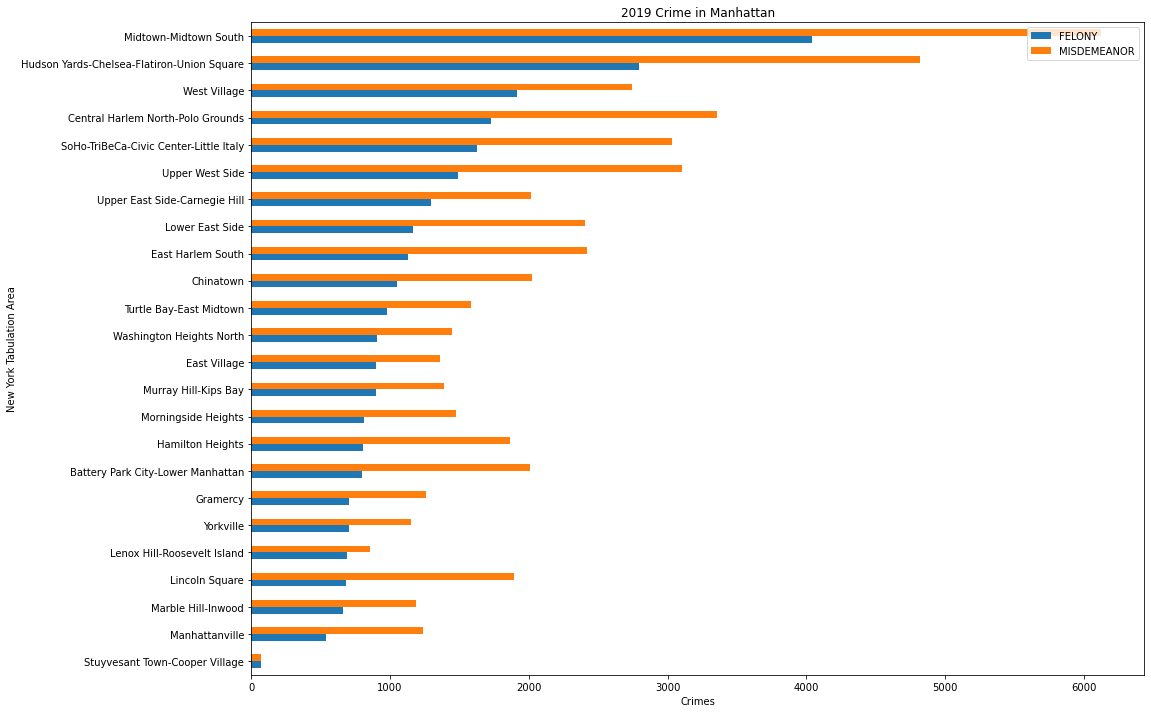

In [126]:
df=crime_df.groupby(['tab_area','LAW_CAT_CD']).size()
df=df.unstack()
df=df.sort_values(by=['FELONY'])
df.plot(kind='barh', figsize=(16, 12))
plt.xlabel('Crimes') # add to x-label to the plot
plt.ylabel('New York Tabulation Area') # add y-label to the plot
plt.title('2019 Crime in Manhattan') # add title to the plot
plt.legend( loc='upper right')
plt.show()

In [252]:
df

LAW_CAT_CD,FELONY,MISDEMEANOR
tab_area,,
Stuyvesant Town-Cooper Village,74,67
Manhattanville,542,1234
Marble Hill-Inwood,659,1189
Lincoln Square,683,1890
Lenox Hill-Roosevelt Island,691,853
Yorkville,703,1149
Gramercy,705,1261
Battery Park City-Lower Manhattan,797,2009
Hamilton Heights,808,1863


Lets do the same with the subway data. We will create a horizontal bar chart to display how many subway entrances there are per tabulation area. We will then create a map to show the exact locations.

In [118]:
subway_df.head()

,Object_ID,URL,Latitude,Longitude,tab_area
0,1734,http://web.mta.info/nyct/service/,40.849169,-73.868356,Van Nest-Morris Park-Westchester Square
1,1735,http://web.mta.info/nyct/service/,40.849128,-73.868213,Van Nest-Morris Park-Westchester Square
2,1736,http://web.mta.info/nyct/service/,40.841223,-73.873499,East Tremont
3,1737,http://web.mta.info/nyct/service/,40.841453,-73.872892,East Tremont
4,1738,http://web.mta.info/nyct/service/,40.840815,-73.879623,East Tremont


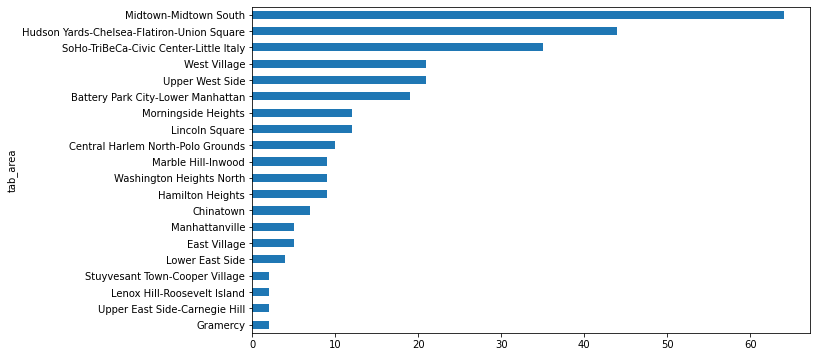

In [149]:
subway_plot=subway_df.groupby(['tab_area']).size()
subway_plot.sort_values(ascending=True).plot(kind='barh',figsize=(10, 6))


In [256]:
subway_map = folium.Map(location=[latitude_ny, longitude_ny], zoom_start=11)
marker_cluster = MarkerCluster().add_to(subway_map)
# add markers to map
for lat, lng, label in zip(subway_df['Latitude'], subway_df['Longitude'], subway_df['tab_area']):
    label = folium.Popup(label, parse_html=True)
    

    folium.Marker(
        [lat, lng],
        popup=label
        ).add_to(marker_cluster)  
    
subway_map

Now we will look at the New York Data. Using Foursquare API we will explore manhattan neighborhoods and venues within them.

Define Foursquare API Credentials

In [161]:
CLIENT_ID = 'KPF4TIL3A2Y2MH1OQXCOC3HLTXLPOWQRMKB5X1ZJUEPDZN3R' # your Foursquare ID
CLIENT_SECRET = 'XHESV5KFAIYQVUCQIQF4ELNMQ4ZZH0F33CPHKSMMISDL5AIT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

We will now start to explore Manhattan Neighborhoods. First we will generate a map for manhattan and display the neighborhoods from our new york city dataset. We use the Geopy library to get the latitude and longitude of Manhattan.

In [3]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_ny = location.latitude
longitude_ny = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude_ny, longitude_ny))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [21]:
manhattan_map = folium.Map(location=[latitude_ny, longitude_ny], zoom_start=12)
ny_geo= r'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON'
# add markers to map
for lat, lng, label in zip(manhattan_df['Latitude'], manhattan_df['Longitude'], manhattan_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        geo_data=ny_geo,
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(manhattan_map)  
    
manhattan_map

We will create a function to get all the venues near each neighborhood using Foursquare API. We limit this to 100 venues.We then append this to a dataframe called manhattan_venues.

In [ ]:

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
    
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)



manhattan_venues = getNearbyVenues(names=manhattan_df['Neighborhood'],
                                   latitudes=manhattan_df['Latitude'],
                                   longitudes=manhattan_df['Longitude']
                                  )

In [177]:
manhattan_venues['tab_area'] =  manhattan_venues.apply(lambda row : define_tab_area(row['Neighborhood Latitude'], row['Neighborhood Longitude']), axis = 1)
manhattan_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,tab_area
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place,Marble Hill-Inwood
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio,Marble Hill-Inwood
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner,Marble Hill-Inwood
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop,Marble Hill-Inwood
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop,Marble Hill-Inwood


Lets check how many venue categories there and have a look at them

In [174]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 326 uniques categories.


In [180]:
manhattan_venues['Venue Category'].unique()    

array(['Pizza Place', 'Yoga Studio', 'Diner', 'Donut Shop', 'Coffee Shop',
       'Gym', 'Pharmacy', 'Department Store', 'Tennis Stadium',
       'Discount Store', 'Supplement Shop', 'Seafood Restaurant',
       'Ice Cream Shop', 'Video Game Store', 'Sandwich Place',
       'Steakhouse', 'Kids Store', 'Big Box Store', 'Deli / Bodega',
       'Hotel', 'Cocktail Bar', 'Greek Restaurant', 'Chinese Restaurant',
       'Spa', 'Bakery', 'Tea Room', 'American Restaurant',
       'New American Restaurant', 'Bubble Tea Shop', 'Roof Deck',
       'Indie Movie Theater', 'Hotpot Restaurant', 'Noodle House',
       'Spanish Restaurant', 'Museum', 'Asian Restaurant', 'Bike Shop',
       'Salon / Barbershop', 'Furniture / Home Store', 'Boutique',
       'Vietnamese Restaurant', 'Thai Restaurant', 'Dessert Shop',
       'Historic Site', 'Italian Restaurant', 'Music Venue',
       'Cosmetics Shop', 'Malay Restaurant', 'Supermarket',
       'Korean Restaurant', 'Dim Sum Restaurant', 'Organic Grocery',
 

As we are looking for the best area to set up a new coffee shop I have selected some similar businesses and created a new dataframe to look at.

In [185]:
manhattan_coffee_shops= manhattan_venues[manhattan_venues['Venue Category'].isin(['Donut Shop', 'Coffee Shop','Sandwich Place','Deli / Bodega','Bakery', 'Tea Room','Bubble Tea Shop','Café','Breakfast Spot','Bagel Shop'])].reset_index(drop=True)
manhattan_coffee_shops.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,tab_area
0,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop,Marble Hill-Inwood
1,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop,Marble Hill-Inwood
2,Marble Hill,40.876551,-73.91066,Starbucks,40.873755,-73.908613,Coffee Shop,Marble Hill-Inwood
3,Marble Hill,40.876551,-73.91066,Subway,40.878465,-73.905518,Sandwich Place,Marble Hill-Inwood
4,Marble Hill,40.876551,-73.91066,Starbucks,40.873234,-73.908730,Coffee Shop,Marble Hill-Inwood


In [186]:
manhattan_coffee_shops.shape

(451, 8)

Lets look at how many of these there are per neighborhood and tabulation area.

In [230]:
manhattan_coffee_shops.groupby(['tab_area', 'Neighborhood']).count()

Neighborhood Latitude  \
tab_area                                   Neighborhood                                 
Battery Park City-Lower Manhattan          Battery Park City                        6   
                                           Financial District                      20   
Central Harlem North-Polo Grounds          Central Harlem                           2   
Chinatown                                  Chinatown                               13   
East Harlem South                          East Harlem                             10   
East Village                               East Village                             7   
                                           Noho                                    11   
Gramercy                                   Gramercy                                15   
Hamilton Heights                           Hamilton Heights                        17   
Hudson Yards-Chelsea-Flatiron-Union Square Chelsea                                 15   
                                           Clinton                                 12   
                                           Flatiron                                 8   
                                           Hudson Yards                             4   
Lenox Hill-Roosevelt Island                Lenox Hill                              15   
                                           Roosevelt Island                         4   
Lincoln Square                             Lincoln Square                           8   
Lower East Side                            Lower East Side                          9   
Manhattanville                             Manhattanville                           7   
Marble Hill-Inwood                         Inwood                                   9   
                                           Marble Hill                              6   
Midtown-Midtown South                      Midtown                                 19   
                                           Midtown South                           10   
Morningside Heights                        Morningside Heights                      9   
Murray Hill-Kips Bay                       Murray Hill                             17   
SoHo-TriBeCa-Civic Center-Little Italy     Civic Center                            14   
                                           Greenwich Village                       13   
                                           Little Italy                            26   
                                           Soho                                    14   
                                           Tribeca                                  8   
Stuyvesant Town-Cooper Village             Stuyvesant Town                          1   
Turtle Bay-East Midtown                    Sutton Place                             9   
                                           Tudor City                              12   
                                           Turtle Bay                              14   
Upper East Side-Carnegie Hill              Carnegie Hill                           14   
                                           Upper East Side                         11   
Upper West Side                            Manhattan Valley                         6   
                                           Upper West Side                         12   
Washington Heights North                   Washington Heights                      18   
West Village                               West Village                            11   
Yorkville                                  Yorkville                               15   

                                                                Neighborhood Longitude  \
tab_area                                   Neighborhood                                  
Battery Park City-Lower Manhattan          Battery Park City                         6   
                                           Financial Di

In [236]:
coffee_map = folium.Map(location=[latitude_ny, longitude_ny], zoom_start=12)

marker_cluster = MarkerCluster().add_to(coffee_map)
for lat, lng, label in zip(manhattan_coffee_shops['Venue Latitude'], manhattan_coffee_shops['Venue Longitude'], manhattan_coffee_shops['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label
        ).add_to(marker_cluster)
    
subway_map.choropleth(
    geo_data=ny_tab_area_json,
    data=manhattan_coffee_shops,
    columns=['Venue Latitude','Venue Longitude'],
    key_on='feature.id',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Coffee Shops'
)

coffee_map

 Now lets analyse each neighborhood. we will take the mean of the frequency of each venue category and create a new dataframe

In [202]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 


# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South American Re

 We will now create a new function to return the top 5 most common venues per neighborhood. We will create a new dataframe to hold this data.

In [ ]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[2:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

In [204]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [205]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Battery Park City,Park,Hotel,Gym,Coffee Shop,Shopping Mall
1,Carnegie Hill,Coffee Shop,Yoga Studio,Pizza Place,Bakery,Bookstore
2,Central Harlem,African Restaurant,Gym / Fitness Center,French Restaurant,Bar,Cosmetics Shop
3,Chelsea,Coffee Shop,Art Gallery,American Restaurant,Italian Restaurant,Hotel
4,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,Vietnamese Restaurant,Dessert Shop


### Cluster Neighborhoods

We are going to cluster the neighborhoods using kmeans. We will create 5 clusters. We will merge the original manhattan_df with the new dataframe containing the top 5 venues

In [206]:
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,tab_area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,Marble Hill-Inwood,4,Coffee Shop,Gym,Discount Store,Yoga Studio,Pizza Place
1,Manhattan,Chinatown,40.715618,-73.994279,Chinatown,1,Chinese Restaurant,Bakery,Cocktail Bar,Vietnamese Restaurant,Dessert Shop
2,Manhattan,Washington Heights,40.851903,-73.936900,Washington Heights North,3,Café,Bakery,Mobile Phone Shop,Chinese Restaurant,New American Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,Marble Hill-Inwood,3,Lounge,Mexican Restaurant,Café,Restaurant,Bakery
4,Manhattan,Hamilton Heights,40.823604,-73.949688,Hamilton Heights,3,Pizza Place,Coffee Shop,Café,Deli / Bodega,Mexican Restaurant


We will now create a map to visualize the clusters

In [208]:
# create map
cluster_ny_map = folium.Map(location=[latitude_ny, longitude_ny], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, tab, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'],manhattan_merged['tab_area'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + str(tab), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(cluster_ny_map)
    
cluster_ny_map

In [237]:
cluster1=manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1,4] + list(range(5, manhattan_merged.shape[1]))]]
cluster1

,Neighborhood,tab_area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,Manhattanville,Manhattanville,0,Coffee Shop,Italian Restaurant,Mexican Restaurant,Bar,Seafood Restaurant
6,Central Harlem,Central Harlem North-Polo Grounds,0,African Restaurant,Gym / Fitness Center,French Restaurant,Bar,Cosmetics Shop
8,Upper East Side,Upper East Side-Carnegie Hill,0,Italian Restaurant,Bakery,Coffee Shop,French Restaurant,Gym / Fitness Center
9,Yorkville,Yorkville,0,Italian Restaurant,Gym,Coffee Shop,Bar,Wine Shop
10,Lenox Hill,Lenox Hill-Roosevelt Island,0,Italian Restaurant,Coffee Shop,Sushi Restaurant,Pizza Place,Café
12,Upper West Side,Upper West Side,0,Italian Restaurant,Coffee Shop,Bakery,Bar,Indian Restaurant
13,Lincoln Square,Lincoln Square,0,Plaza,Italian Restaurant,Theater,Concert Hall,Performing Arts Venue
17,Chelsea,Hudson Yards-Chelsea-Flatiron-Union Square,0,Coffee Shop,Art Gallery,American Restaurant,Italian Restaurant,Hotel
18,Greenwich Village,SoHo-TriBeCa-Civic Center-Little Italy,0,Italian Restaurant,Sushi Restaurant,Café,Clothing Store,Chinese Restaurant
19,East Village,East Village,0,Bar,Pizza Place,Ice Cream Shop,Mexican Restaurant,Wine Bar


In [238]:
cluster1['Neighborhood'].unique()

array(['Manhattanville', 'Central Harlem', 'Upper East Side', 'Yorkville',
       'Lenox Hill', 'Upper West Side', 'Lincoln Square', 'Chelsea',
       'Greenwich Village', 'East Village', 'Tribeca', 'Little Italy',
       'Soho', 'West Village', 'Gramercy', 'Carnegie Hill', 'Noho',
       'Sutton Place', 'Turtle Bay'], dtype=object)

In [257]:
cluster1['tab_area'].unique()

array(['Manhattanville', 'Central Harlem North-Polo Grounds',
       'Upper East Side-Carnegie Hill', 'Yorkville',
       'Lenox Hill-Roosevelt Island', 'Upper West Side', 'Lincoln Square',
       'Hudson Yards-Chelsea-Flatiron-Union Square',
       'SoHo-TriBeCa-Civic Center-Little Italy', 'East Village',
       'West Village', 'Gramercy', 'Turtle Bay-East Midtown'],
      dtype=object)

In [241]:
cluster2=manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1,4] + list(range(5, manhattan_merged.shape[1]))]]
cluster2


,Neighborhood,tab_area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Chinatown,Chinatown,1,Chinese Restaurant,Bakery,Cocktail Bar,Vietnamese Restaurant,Dessert Shop
14,Clinton,Hudson Yards-Chelsea-Flatiron-Union Square,1,Theater,Gym / Fitness Center,Gym,Coffee Shop,American Restaurant
15,Midtown,Midtown-Midtown South,1,Coffee Shop,Clothing Store,Hotel,Bakery,Theater
16,Murray Hill,Murray Hill-Kips Bay,1,Hotel,Sandwich Place,Japanese Restaurant,Coffee Shop,American Restaurant
20,Lower East Side,Lower East Side,1,Art Gallery,Chinese Restaurant,Coffee Shop,Ramen Restaurant,Japanese Restaurant
28,Battery Park City,Battery Park City-Lower Manhattan,1,Park,Hotel,Gym,Coffee Shop,Shopping Mall
29,Financial District,Battery Park City-Lower Manhattan,1,Coffee Shop,Pizza Place,Cocktail Bar,Italian Restaurant,Gym / Fitness Center
32,Civic Center,SoHo-TriBeCa-Civic Center-Little Italy,1,Coffee Shop,Hotel,Cocktail Bar,Gym / Fitness Center,Yoga Studio
33,Midtown South,Midtown-Midtown South,1,Korean Restaurant,Hotel,Dessert Shop,Japanese Restaurant,Coffee Shop
38,Flatiron,Hudson Yards-Chelsea-Flatiron-Union Square,1,New American Restaurant,Italian Restaurant,Japanese Restaurant,Mediterranean Restaurant,Sporting Goods Shop


In [258]:
cluster2['Neighborhood'].unique()

array(['Chinatown', 'Clinton', 'Midtown', 'Murray Hill',
       'Lower East Side', 'Battery Park City', 'Financial District',
       'Civic Center', 'Midtown South', 'Flatiron', 'Hudson Yards'],
      dtype=object)

In [259]:
cluster2['tab_area'].unique()

array(['Chinatown', 'Hudson Yards-Chelsea-Flatiron-Union Square',
       'Midtown-Midtown South', 'Murray Hill-Kips Bay', 'Lower East Side',
       'Battery Park City-Lower Manhattan',
       'SoHo-TriBeCa-Civic Center-Little Italy'], dtype=object)

In [242]:
cluster3=manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1,4] + list(range(5, manhattan_merged.shape[1]))]]
cluster3

,Neighborhood,tab_area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
37,Stuyvesant Town,Stuyvesant Town-Cooper Village,2,Park,Boat or Ferry,Bar,Farmers Market,Heliport


In [243]:
cluster4=manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1,4] + list(range(5, manhattan_merged.shape[1]))]]
cluster4

,Neighborhood,tab_area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Washington Heights,Washington Heights North,3,Café,Bakery,Mobile Phone Shop,Chinese Restaurant,New American Restaurant
3,Inwood,Marble Hill-Inwood,3,Lounge,Mexican Restaurant,Café,Restaurant,Bakery
4,Hamilton Heights,Hamilton Heights,3,Pizza Place,Coffee Shop,Café,Deli / Bodega,Mexican Restaurant
7,East Harlem,East Harlem South,3,Mexican Restaurant,Thai Restaurant,Bakery,Deli / Bodega,Sandwich Place
11,Roosevelt Island,Lenox Hill-Roosevelt Island,3,Park,Soccer Field,Bubble Tea Shop,Metro Station,School
25,Manhattan Valley,Upper West Side,3,Bar,Mexican Restaurant,Pizza Place,Park,Coffee Shop
26,Morningside Heights,Morningside Heights,3,Park,Bookstore,American Restaurant,Coffee Shop,Deli / Bodega
36,Tudor City,Turtle Bay-East Midtown,3,Park,Mexican Restaurant,Café,Deli / Bodega,Sushi Restaurant


In [244]:
cluster5=manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1,4] + list(range(5, manhattan_merged.shape[1]))]]
cluster5

,Neighborhood,tab_area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Marble Hill,Marble Hill-Inwood,4,Coffee Shop,Gym,Discount Store,Yoga Studio,Pizza Place


## 4. Results and Discussion

### Clustering Results

From the five clusters created, they were broken down into the following:<br>
    
Cluster 1 – Restaurants/Coffee Shops – Cluster 1 consisted of mainly Restaurants and Coffee Shops<br>
Cluster 2 – Hotel cluster – Cluster 2 consisted of hotels and restauarants/coffee shops again. A lot of these locations around the financial district which could attract businesspeople that would be staying in hotels and tourists.<br>
Cluster 3 – Tourism cluster – There is only one neighborhood listed here which has a park and a boat/ferry which would indicate tourism. There is currently only one coffee shop listed in this neighborhood which may indicate there is not a lot of business here.<br>
Cluster 4 – international – There is a diverse range of food options in this cluster. There are also a lot of parks. <br>
Cluster 5 – There is only one neighborhood here again so it would be too difficult to decide on a name for this cluster.


### Discussion

After analysing each cluster, Cluster 1 and Cluster 2 appear to have the best mix of venues and neighborhoods where a new coffee shop should be set up.<br>


    
From these clusters and the above analysis on crime and subway data the best locations to set up a new boutique coffee shop are:<br>

Battery Park City<br>
Financial District<br>
Chelsea<br>
Clinton<br>
Flatiron<br>
Hudson Yards<br>
Civic Center<br>
Greenwich Village<br>
Little Italy<br>
Soho<br>
Tribeca<br>




Hudson Yards-Chelsea-Flatiron-Union Square and Soho-TriBeCa-Civi Center-Little Italy both have high crime rates. They also have the most subway entrances so they would be convenient locations for employees. <br>
Battery Park City- Lower Manhattan has a much lower crime rate and has a lot of subway entrances which makes it an ideal location. Coffee shops place in the top five venues for both Battery Park City and Financial District.


## Conclusion

In this analysis,  New York city neighborhood data, neighborhood tabulation data, crime data, subway entrances data and Foursquare API Venue data was analysed to determine what the best Manhattan neighborhood would be to open up a new boutique coffee shop. 
It was determined that Battery Park City or Financial District Neighborhoods would be the best locations due to popular venues nearby such as hotels, coffee shops, gyms, low crime rates in the area and a lot of subway entrances.
